Набор данных включает в себя медицинские и демографических данные
для прогнозирования наличия или отсутствия у пациента диабета.
Мы будем разрабатывать прогностическую модель, которая на основе
анамнеза пациента и текущих клинических показателей сможет оценить
вероятность наличия диабета.

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')
from imblearn.over_sampling import SMOTE

In [28]:
path="C:/Users/eugen/PycharmProjects/CLUSTER/diabetes_prediction_dataset.csv"
datafile = pd.read_csv(path)
print(datafile.shape)

(100000, 9)


In [29]:
pd.set_option('display.max_columns', None)

print(datafile.head())
print(datafile.tail())

print(datafile.columns)

   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  
       gender   age  hypertension  heart_disease smoking_history    bmi  \
99995  Female  80.0             0              0         No Info  27.32   
99996  Female   2.0             0              0         No Info  17.37   
99997    Male  66.0             0              0          fo

Мы вывели список первых пяти и последних пяти строк. Каждая из них описывает пациента.
Каждый пациент характеризуется следующим набором признаков:
* gender - пол пациента
* age - возраст пациента
* hypertension - наличие или отсутствие у пациента артериальной гипертензии
* heart_disease - наличие или отсутствие сердечных заболеваний
* smoking_history - история курения пациента
* bmi - индекс массы тела
* HbA1c_level - уровень гликированного гемоглобина(средний уровень глюкозы в крови за 2-3 месяца)
* blood_glucose_level - уровень глюкозы в крови
* diabetes - наличие или отсутствие диабета у пациента

Признак diabetes является целевым. Наша задача научится предсказывать значение признака diabetes по остальным признакам.

In [30]:
datafile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [31]:
datafile['gender'] = datafile['gender'].astype('category')
datafile['smoking_history'] = datafile['smoking_history'].astype('category')
print(datafile.describe(include=['category']))

        gender smoking_history
count   100000          100000
unique       3               6
top     Female         No Info
freq     58552           35816


Можно заметить наличие 3-х уникальных значений признака gender. Проведем
базовую очистку данных для обеспечения качества анализа.

In [32]:
datafile = datafile[datafile['gender'].isin(['Male', 'Female'])]
datafile['gender'] = datafile['gender'].astype('category')
datafile['smoking_history'] = datafile['smoking_history'].astype('category')

print(datafile.describe(include=['category']))

        gender smoking_history
count    99982           99982
unique       2               6
top     Female         No Info
freq     58552           35810


Приведем статистику по категориальным признакам:

In [33]:
print(datafile['gender'].value_counts())
print(datafile['smoking_history'].value_counts())

gender
Female    58552
Male      41430
Other         0
Name: count, dtype: int64
smoking_history
No Info        35810
never          35092
former          9352
current         9286
not current     6439
ever            4003
Name: count, dtype: int64


Статистика по числовым признакам:

In [34]:
print(datafile.describe())
key_insights = {
    "Средний возраст": f"{datafile.describe().loc['mean', 'age']:.1f} лет",
    "Распространенность гипертонии": f"{datafile.describe().loc['mean', 'hypertension'] * 100:.1f}%",
    "Распространенность болезней сердца": f"{datafile.describe().loc['mean', 'heart_disease'] * 100:.1f}%",
    "Средний ИМТ": f"{datafile.describe().loc['mean', 'bmi']:.1f}",
    "Средний уровень HbA1c": f"{datafile.describe().loc['mean', 'HbA1c_level']:.1f}",
    "Средний уровень глюкозы": f"{datafile.describe().loc['mean', 'blood_glucose_level']:.1f}",
    "Распространенность диабета": f"{datafile.describe().loc['mean', 'diabetes'] * 100:.1f}%"
}

print('\n')
for insight, value in key_insights.items():
    print(f"• {insight}: {value}")

print(f"\nРазброс данных (стандартное отклонение):")
print(f"• Возраст: ±{datafile.describe().loc['std', 'age']:.1f} лет")
print(f"• ИМТ: ±{datafile.describe().loc['std', 'bmi']:.1f}")
print(f"• Уровень глюкозы: ±{datafile.describe().loc['std', 'blood_glucose_level']:.1f}")

                age  hypertension  heart_disease           bmi   HbA1c_level  \
count  99982.000000  99982.000000   99982.000000  99982.000000  99982.000000   
mean      41.888076      0.074863       0.039427     27.320757      5.527529   
std       22.517206      0.263172       0.194610      6.636853      1.070665   
min        0.080000      0.000000       0.000000     10.010000      3.500000   
25%       24.000000      0.000000       0.000000     23.630000      4.800000   
50%       43.000000      0.000000       0.000000     27.320000      5.800000   
75%       60.000000      0.000000       0.000000     29.580000      6.200000   
max       80.000000      1.000000       1.000000     95.690000      9.000000   

       blood_glucose_level      diabetes  
count         99982.000000  99982.000000  
mean            138.057810      0.085015  
std              40.709469      0.278906  
min              80.000000      0.000000  
25%             100.000000      0.000000  
50%             140.0

Проведем анализ зависимости между признаками:

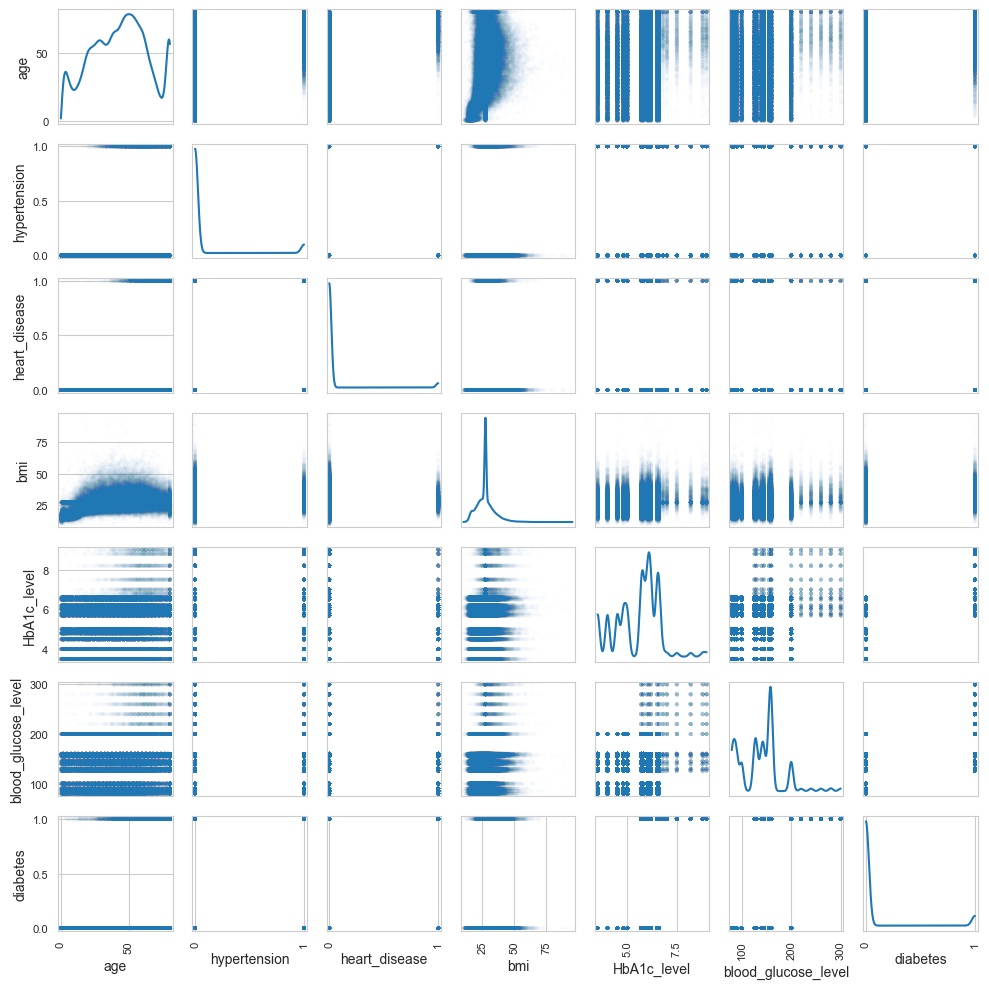

In [35]:
from pandas.plotting import scatter_matrix

scatter_matrix(datafile, alpha=.01, figsize=(10, 10), diagonal='kde')
plt.tight_layout()
plt.show()

Построим матрицу корреляции между числовыми признаками:

                          age  hypertension  heart_disease       bmi  \
age                  1.000000      0.251163       0.233352  0.337378   
hypertension         0.251163      1.000000       0.121253  0.147679   
heart_disease        0.233352      0.121253       1.000000  0.061203   
bmi                  0.337378      0.147679       0.061203  1.000000   
HbA1c_level          0.101343      0.080941       0.067591  0.083017   
blood_glucose_level  0.110679      0.084436       0.070071  0.091310   
diabetes             0.257999      0.197811       0.171718  0.214377   

                     HbA1c_level  blood_glucose_level  diabetes  
age                     0.101343             0.110679  0.257999  
hypertension            0.080941             0.084436  0.197811  
heart_disease           0.067591             0.070071  0.171718  
bmi                     0.083017             0.091310  0.214377  
HbA1c_level             1.000000             0.166831  0.400696  
blood_glucose_level     0.1

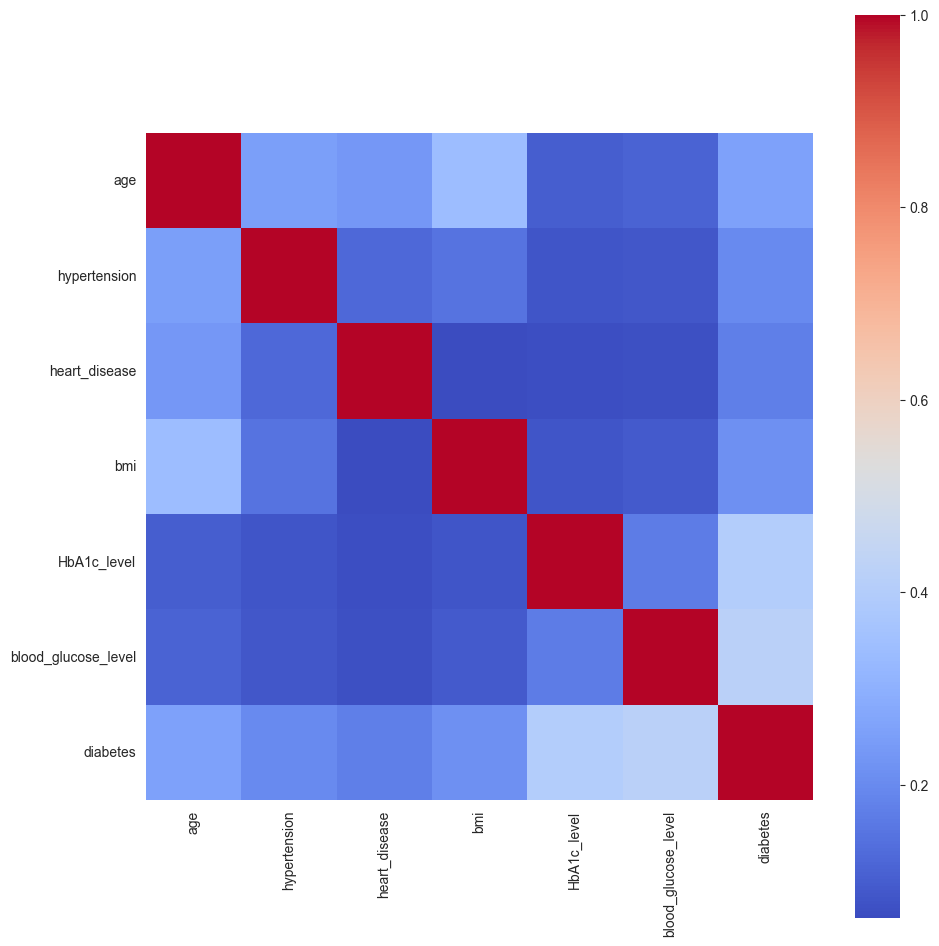

In [36]:
corr_matrix = datafile.corr(numeric_only=True)
print(corr_matrix)
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, square=True, cmap='coolwarm')
plt.tight_layout()
plt.show()

Исследуем распределение признаков:

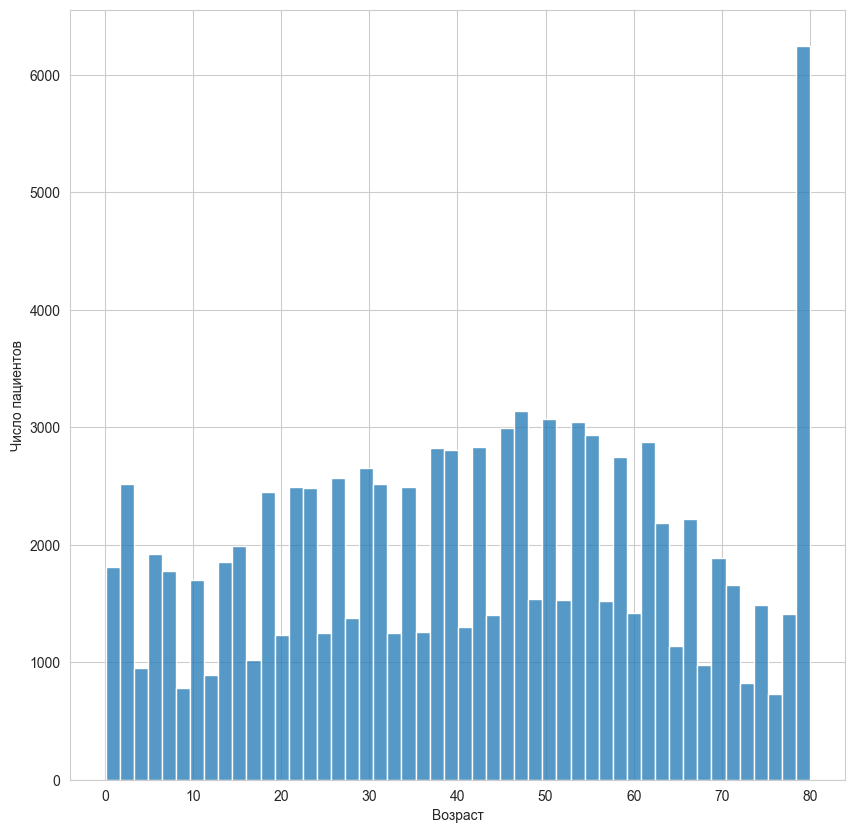

In [37]:
plt.figure(figsize=(10, 10))
sns.histplot(datafile['age'], bins = 50, kde_kws={'color': 'skyblue'})
plt.xlabel('Возраст')
plt.ylabel('Число пациентов')
plt.show()

Распределение возраста пациентов относительно равномерно.

Исключение составляют пациенты возраста 80 лет, их количество сильно
превалирует. Однако это соответствует реальности, вследствие чего может добавить модели информативности.

Исследуем зависимость между полом пациента и наличием у него диабета:

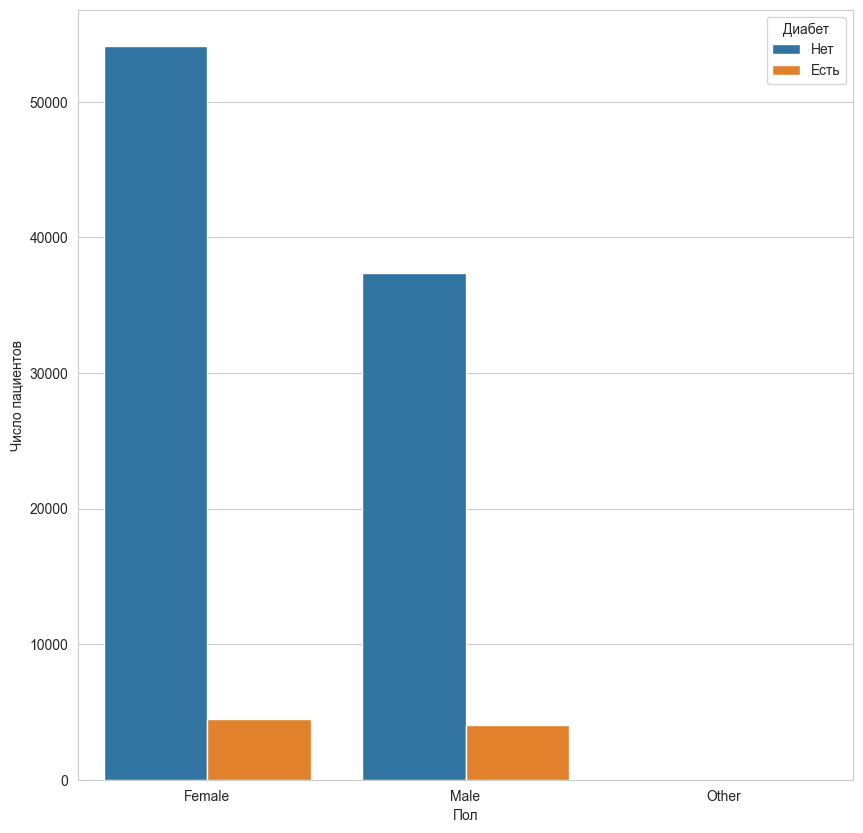

In [38]:
plt.figure(figsize=(10, 10))
sns.countplot(data = datafile, x = 'gender', hue = 'diabetes')
plt.xlabel('Пол')
plt.ylabel('Число пациентов')
plt.legend(title = 'Диабет', labels = ['Нет', 'Есть'])
plt.show()

In [39]:
gender_diabetes = datafile.groupby('gender', observed=False)['diabetes'].mean() * 100
print(f"Распространенность диабета по полу:")
for gender, rate in gender_diabetes.items():
    print(f"• {gender}: {rate:.2f}%")

Распространенность диабета по полу:
• Female: 7.62%
• Male: 9.75%
• Other: nan%


Исследуем
распространение
категориальных
переменных:

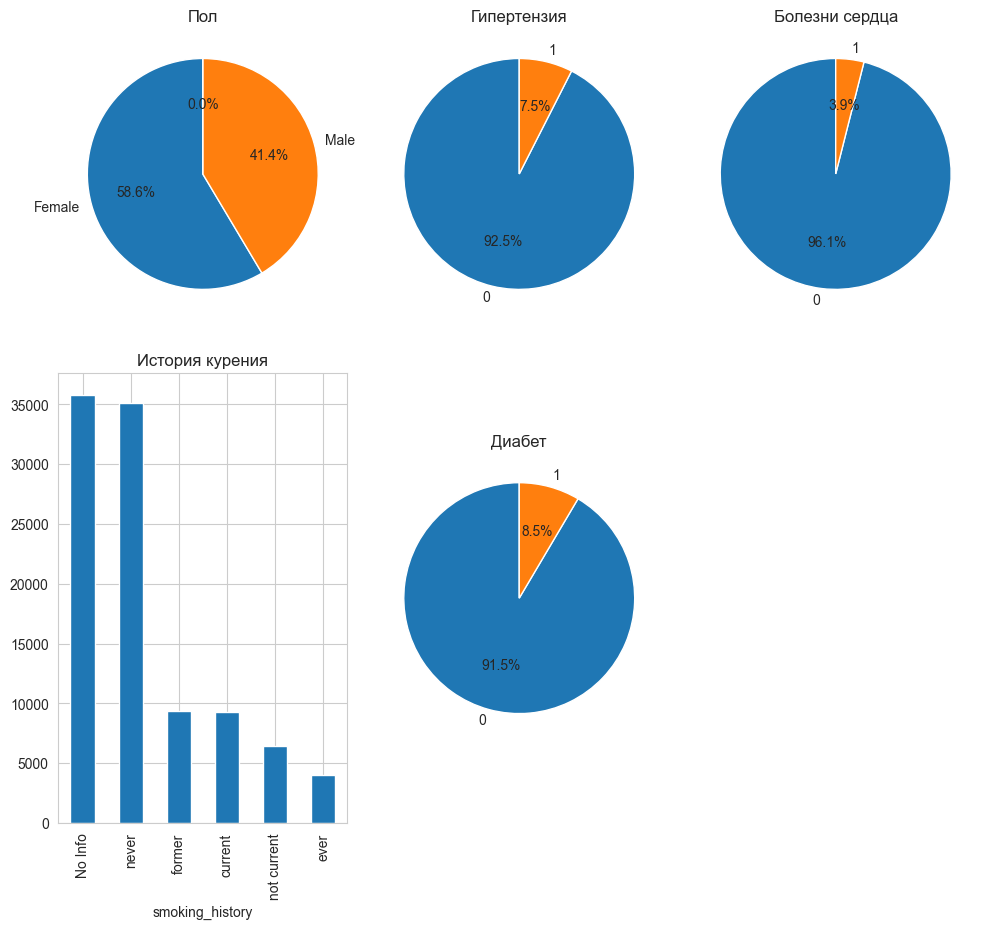

In [40]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 10))
axes = axes.ravel()

vars = ['gender', 'hypertension', 'heart_disease', 'smoking_history', 'diabetes']
titles = ['Пол', 'Гипертензия', 'Болезни сердца', 'История курения', 'Диабет']

for i, (var, title) in enumerate(zip(vars, titles)):
    counts = datafile[var].value_counts()
    if var == 'smoking_history':
        counts.plot(kind='bar', stacked=True, ax=axes[i])
        axes[i].set_title(title)
    else:
        counts.plot(kind='pie', autopct='%1.1f%%', stacked=True, ax=axes[i], startangle=90)
        axes[i].set_ylabel('')
        axes[i].set_title(title)
fig.delaxes(axes[5])
plt.tight_layout()
plt.show()

Есть небольшой дисбаланс в распределении по половому признаку

Дисбаланс по другим признакам объясняется естественными причинами

Обработка выбросов:

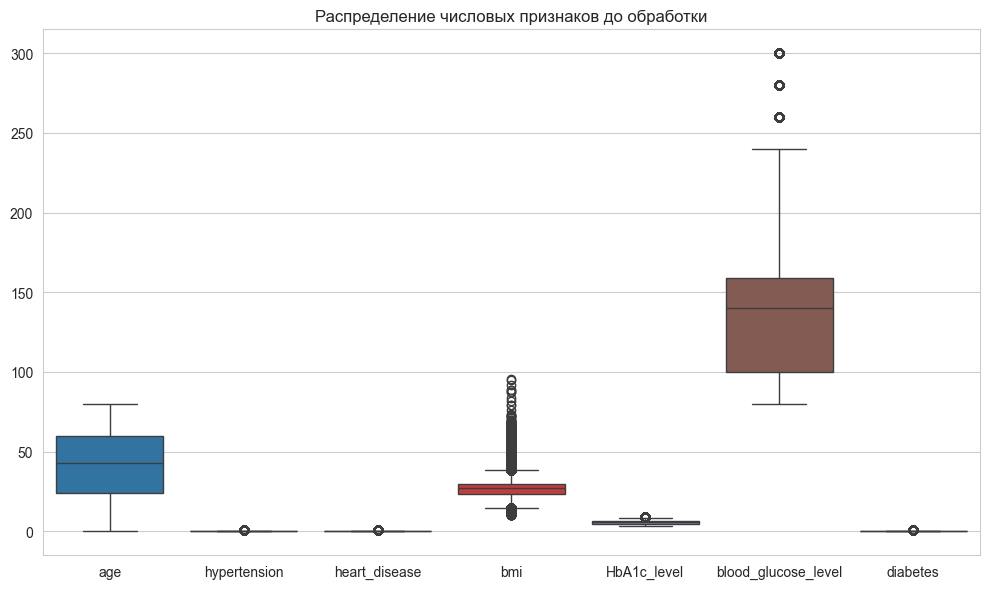

In [41]:
plt.figure(figsize=(10, 6))
sns.boxplot(data = datafile.select_dtypes(include=[np.number]))
plt.title('Распределение числовых признаков до обработки')
plt.tight_layout()
plt.show()

(96366, 9)


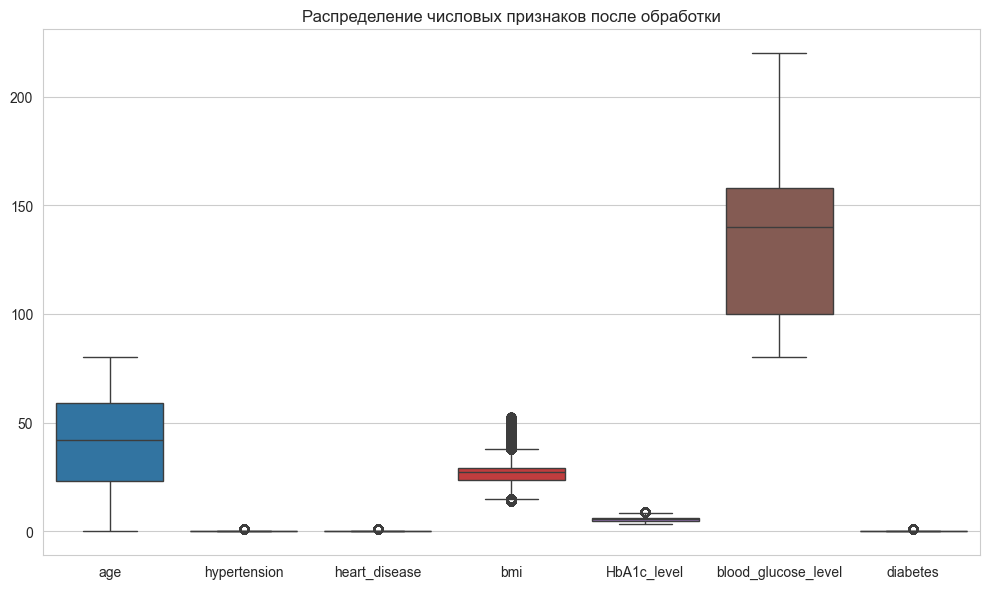

In [42]:
bmi_lower = datafile['bmi'].quantile(0.005)
bmi_upper = datafile['bmi'].quantile(0.995)

glucose_upper = datafile['blood_glucose_level'].quantile(0.97)

rows_to_drop = datafile[(datafile['bmi'] < bmi_lower)
                        | (datafile['bmi'] > bmi_upper) | (datafile['blood_glucose_level'] > glucose_upper)].index
datafile.drop(rows_to_drop, inplace=True)

print(datafile.shape)

plt.figure(figsize=(10, 6))
sns.boxplot(data = datafile.select_dtypes(include=[np.number]))
plt.title('Распределение числовых признаков после обработки')
plt.tight_layout()
plt.show()

Проведем обработку пропущенных значений:

In [43]:
print(datafile.isnull().sum())

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


Явные пропуски отсутствуют, однако, мы уже замечали неявные пропуски в поле gender. Пропуски в поле gender были малочисленны, их мы уже удалили. Однако при рассмотрении уникальных значений поля 'smoking_history' было обнаружено значение 'No Info'. Обработаем пропуски в smoking_history:

In [44]:
print((datafile['smoking_history'] == 'No Info').sum())

34806


Всего насчитывается 34806 записи с отсутствующей информацией о курении пациента. Данное значение очень велико, поэтому просто исключить данные поля нельзя. Проведем сравнительный анализ группы 'No Info' и остальных групп.



In [45]:
no_info = datafile['smoking_history'] == 'No Info'
no_info_subset = datafile[no_info]
other_subset = datafile[~no_info]


no_info_stats = no_info_subset.describe().loc[['mean', 'std']]
other_stats = other_subset.describe().loc[['mean', 'std']]

comparison_stats = pd.concat({
    'No Info группа': no_info_stats,
    'Остальные пациенты': other_stats
}, axis=1)

display(comparison_stats)

No Info группа                                                    \
                age hypertension heart_disease        bmi HbA1c_level   
mean      33.493879     0.031661      0.024536  25.318428    5.440953   
std       24.796149     0.175099      0.154708   5.964374    1.005127   

                                   Остальные пациенты               \
     blood_glucose_level  diabetes                age hypertension   
mean          133.377636  0.027323          46.065135     0.091927   
std            34.435447  0.163025          19.512015     0.288925   

                                                                         
     heart_disease        bmi HbA1c_level blood_glucose_level  diabetes  
mean      0.043600  28.141878    5.515361          134.977648  0.077404  
std       0.204205   6.026235    1.065098           34.567932  0.267234

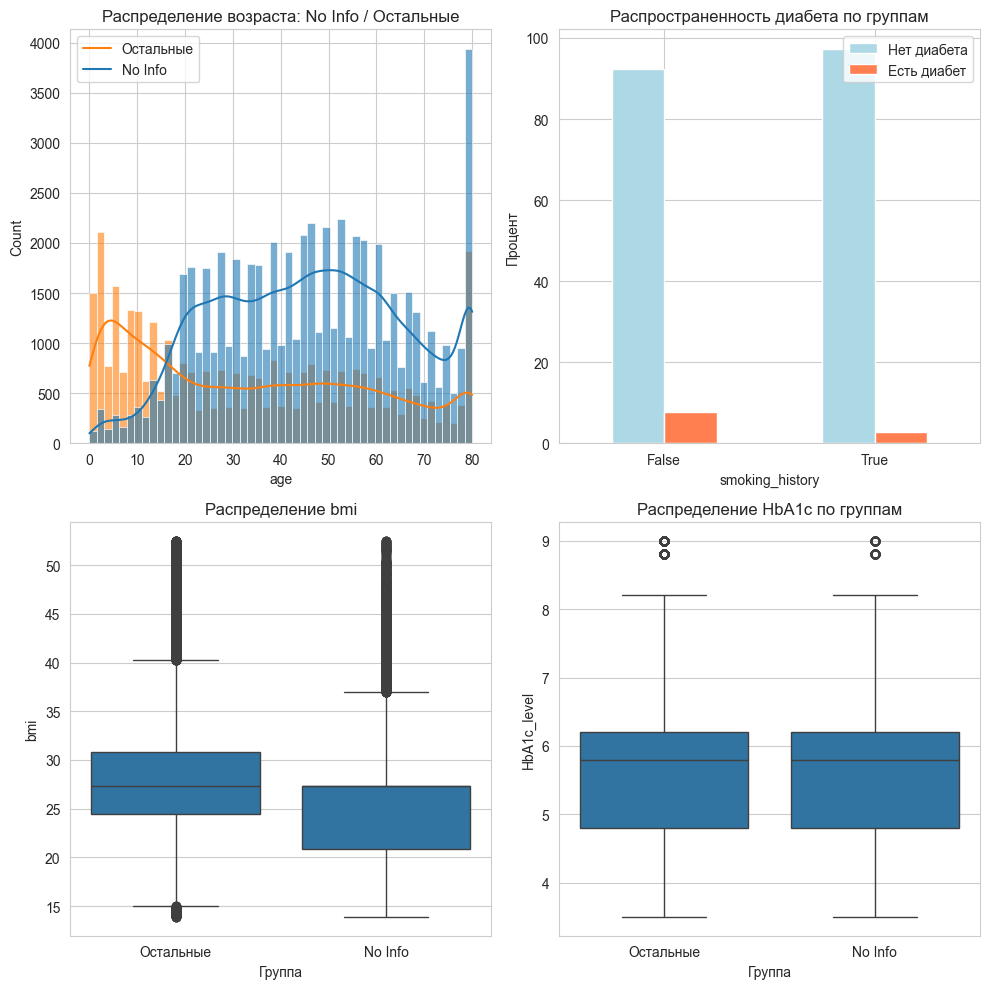

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

sns.histplot(data=datafile, x='age', hue=no_info, ax=axes[0,0], kde=True, alpha=0.6)
axes[0,0].set_title('Распределение возраста: No Info / Остальные')
axes[0,0].legend(['Остальные', 'No Info'])

diabetes_comparison = pd.crosstab(no_info, datafile['diabetes'], normalize='index') * 100
diabetes_comparison.plot(kind='bar', ax=axes[0,1], color=['lightblue', 'coral'])
axes[0,1].set_title('Распространенность диабета по группам')
axes[0,1].set_ylabel('Процент')
axes[0,1].legend(['Нет диабета', 'Есть диабет'])
axes[0,1].tick_params(axis='x', rotation=0)

sns.boxplot(data=datafile, x=no_info, y='bmi', ax=axes[1,0])
axes[1,0].set_title('Распределение bmi')
axes[1,0].set_xlabel('Группа')
axes[1,0].set_xticklabels(['Остальные', 'No Info'])

sns.boxplot(data=datafile, x=no_info, y='HbA1c_level', ax=axes[1,1])
axes[1,1].set_title('Распределение HbA1c по группам')
axes[1,1].set_xlabel('Группа')
axes[1,1].set_xticklabels(['Остальные', 'No Info'])

plt.tight_layout()
plt.show()

Проведем анализ закономерности в пропусках

In [47]:
contingency_table = pd.crosstab(no_info, datafile['diabetes'])
chi2, p_value, _, _ = chi2_contingency(contingency_table)

print(f'p-value : {p_value}')
if p_value < 0.05:
    print(f'пропуски не случайны')
else:
    print(f'пропуски случайны')

p-value : 3.678671003011482e-219
пропуски не случайны


Далее обработаем категориальные признаки:

In [48]:
datafile.info()

num_columns = [c for c in datafile.columns if datafile[c].dtype.name != 'category' and c != 'diabetes']
category_columns = [c for c in datafile.columns if datafile[c].dtype.name == 'category']
data_describe = datafile.describe(include=['category'])
binary_columns = [category for category in category_columns if data_describe[category]['unique'] == 2]
non_binary_columns = [category for category in category_columns if data_describe[category]['unique'] > 2]

for column in binary_columns:
    datafile = datafile.replace({column: {'Female': 0, 'Male': 1}})


smoking_history_dummies = pd.get_dummies(datafile['smoking_history'])
datafile = pd.concat((datafile, smoking_history_dummies.astype(int)), axis=1)
datafile = datafile.drop(['smoking_history'], axis=1)
print(datafile.head())

<class 'pandas.core.frame.DataFrame'>
Index: 96366 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   gender               96366 non-null  category
 1   age                  96366 non-null  float64 
 2   hypertension         96366 non-null  int64   
 3   heart_disease        96366 non-null  int64   
 4   smoking_history      96366 non-null  category
 5   bmi                  96366 non-null  float64 
 6   HbA1c_level          96366 non-null  float64 
 7   blood_glucose_level  96366 non-null  int64   
 8   diabetes             96366 non-null  int64   
dtypes: category(2), float64(3), int64(4)
memory usage: 6.1 MB
  gender   age  hypertension  heart_disease    bmi  HbA1c_level  \
0      0  80.0             0              1  25.19          6.6   
1      0  54.0             0              0  27.32          6.6   
2      1  28.0             0              0  27.32          5.7   
3    

Проведем нормализацию числовых признаков:

In [49]:
print("Анализ масштабов признаков:")
scale_analysis = pd.DataFrame({
    'Минимум': datafile[num_columns].min(),
    'Максимум': datafile[num_columns].max(),
    'Размах': datafile[num_columns].max() - datafile[num_columns].min(),
    'Среднее': datafile[num_columns].mean(),
    'Стандартное отклонение': datafile[num_columns].std()
})

display(scale_analysis)

Анализ масштабов признаков:


,Минимум,Максимум,Размах,Среднее,Стандартное отклонение
age,0.08,80.0,79.92,41.524580,22.399596
hypertension,0.00,1.0,1.00,0.070160,0.255417
heart_disease,0.00,1.0,1.00,0.036714,0.188060
bmi,13.89,52.5,38.61,27.122088,6.155209
HbA1c_level,3.50,9.0,5.50,5.488486,1.044441
blood_glucose_level,80.00,220.0,140.00,134.399747,34.528515


Признаки имеют разный масштаб и значительно отличаются по разбросу.

Принимая эти свойства во внимание, а также учитывая чувствительность некоторых методов к масштабу, следует нормализовать данные.

In [50]:
datafile_norm = (datafile[num_columns] - datafile[num_columns].mean()) / datafile[num_columns].std()

new = pd.DataFrame({
    'После нормализации (среднее)': datafile_norm[num_columns].mean(),
    'После нормализации (std)': datafile_norm[num_columns].std()
})

display(new)

datafile_final = pd.concat([datafile_norm, datafile['gender'], datafile['No Info'],
                           datafile['current'], datafile['ever'], datafile['former'],
                           datafile['never'], datafile['not current'],  datafile['diabetes']], axis=1)
display(datafile_final.shape)
print(datafile_final.head())

,После нормализации (среднее),После нормализации (std)
age,2.641143e-16,1.0
hypertension,3.952129e-17,1.0
heart_disease,1.356701e-17,1.0
bmi,7.373376e-19,1.0
HbA1c_level,-3.981623e-18,1.0
blood_glucose_level,4.188077e-16,1.0


(96366, 14)

        age  hypertension  heart_disease       bmi  HbA1c_level  \
0  1.717684     -0.274686       5.122221 -0.313895     1.064219   
1  0.556948     -0.274686      -0.195226  0.032154     1.064219   
2 -0.603787     -0.274686      -0.195226  0.032154     0.202514   
3 -0.246637     -0.274686      -0.195226 -0.596582    -0.467700   
4  1.539109      3.640478       5.122221 -1.134338    -0.659190   

   blood_glucose_level gender  No Info  current  ever  former  never  \
0             0.162192      0        0        0     0       0      1   
1            -1.575502      0        1        0     0       0      0   
2             0.683500      1        0        0     0       0      1   
3             0.596616      0        0        1     0       0      0   
4             0.596616      1        0        1     0       0      0   

   not current  diabetes  
0            0         0  
1            0         0  
2            0         0  
3            0         0  
4            0         0  


In [51]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from sklearn.metrics import adjusted_rand_score, mutual_info_score
from scipy.stats import entropy

Решение задачи кластеризации

In [53]:
X = datafile_final.drop('diabetes', axis=1)
y = datafile_final['diabetes']

In [54]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

KMeans

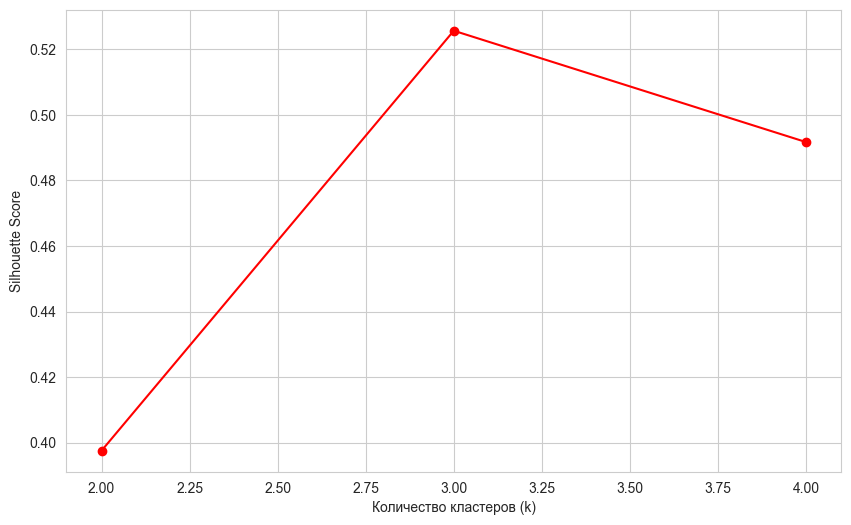

In [55]:
from sklearn.metrics import silhouette_score

range_k = range(2, 5)
silhouette_scores = []
for k in range_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    cluster_labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(X_pca, cluster_labels))

plt.figure(figsize=(10, 6))
plt.plot(range_k, silhouette_scores, marker='o', color='red')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Silhouette Score')
plt.show()

Лучшее значение k = 3

In [58]:
sample_size = 60000
sample_indices = np.random.choice(len(X_pca), size=sample_size, replace = False)
X_sample = X_pca[sample_indices]
y_sample = y.iloc[sample_indices]

In [59]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_sample)
cluster_labels = kmeans.labels_
silhouette_score_kmeans = metrics.silhouette_score(X_sample, cluster_labels)
ari_kmeans = adjusted_rand_score(y_sample, cluster_labels)
mi = mutual_info_score(y_sample, cluster_labels)
h_y = entropy(y_sample)
h_c = entropy(cluster_labels)
nmi_kmeans = (2 * mi) / (h_y + h_c)

print('Силуэтный коэффициент:', silhouette_score_kmeans)
print('ARI:', ari_kmeans)
print('NMI:', nmi_kmeans)

Силуэтный коэффициент: 0.5261047951587816
ARI: 0.013077181664250957
NMI: 0.0021860999799770747


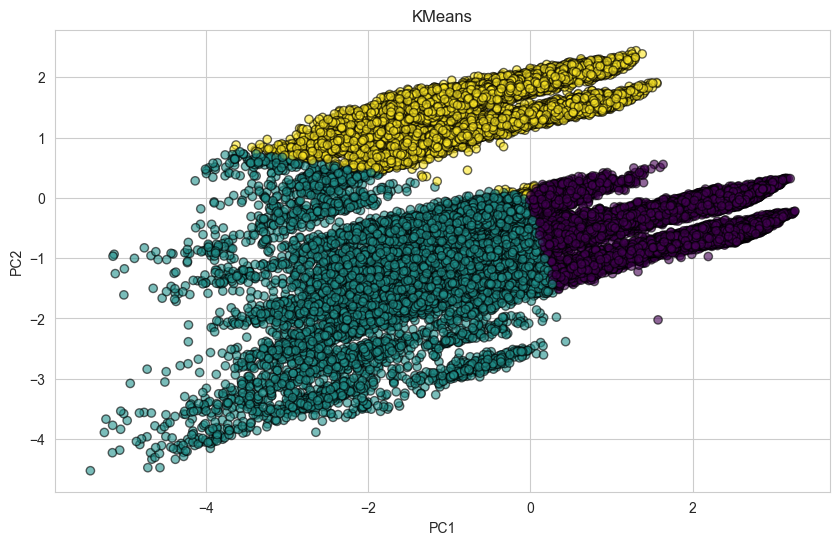

In [60]:
plt.figure(figsize=(10, 6))
plt.scatter(X_sample[:, 0], X_sample[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6, edgecolors='black', linewidths=1)
plt.title('KMeans')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

DBSCAN

In [68]:
dbscan = DBSCAN(eps=0.3, min_samples=5)
dbscan.fit(X_sample)
dbscan_labels = dbscan.labels_
silhouette_score_dbscan = metrics.silhouette_score(X_sample, dbscan_labels)
ari_dbscan = adjusted_rand_score(y_sample, dbscan_labels)
mi = mutual_info_score(y_sample, dbscan_labels)
h_y = entropy(y_sample)
h_c = entropy(dbscan_labels)
nmi_dbscan = (2 * mi) / (h_y + h_c)

print('Силуэтный коэффициент:', silhouette_score_dbscan)
print('ARI:', ari_dbscan)
print('NMI:', nmi_dbscan)

Силуэтный коэффициент: 0.5254264277641758
ARI: 0.002905041186185406
NMI: 3.687547773660231e-05


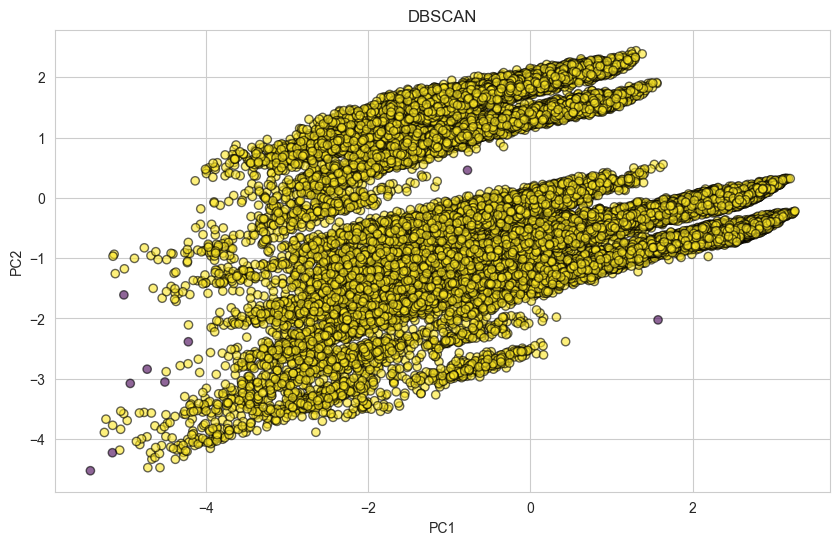

In [69]:
plt.figure(figsize=(10, 6))
plt.scatter(X_sample[:, 0], X_sample[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.6, edgecolors='black', linewidths=1)
plt.title('DBSCAN')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

GMM

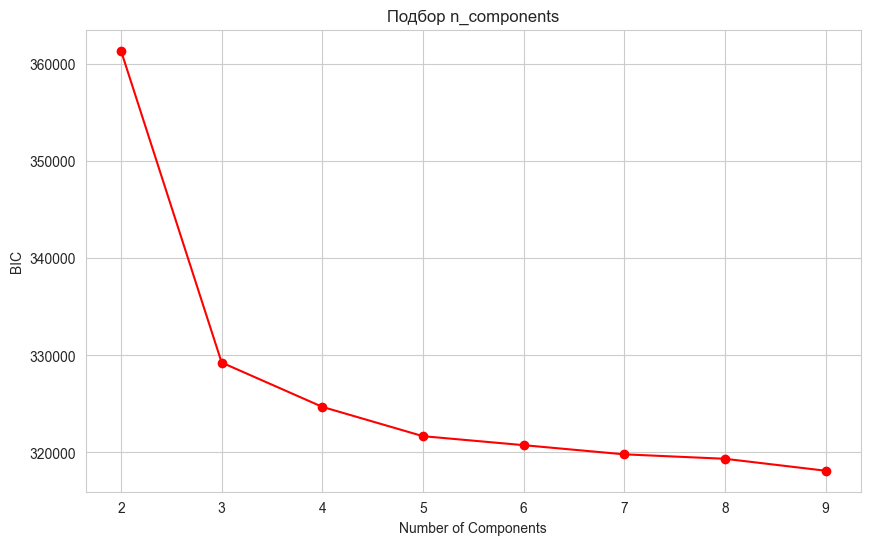

In [75]:
n_components_range = range(2, 10)
bic_scores = []
for n in n_components_range:
    gm = GaussianMixture(n_components=n, random_state=42)
    gm.fit(X_sample)
    bic_scores.append(gm.bic(X_sample))

plt.figure(figsize=(10, 6))
plt.plot(n_components_range, bic_scores, marker='o', color='red')
plt.xlabel('Number of Components')
plt.ylabel('BIC')
plt.title('Подбор n_components')
plt.show()

Лучшее значение n = 7

In [78]:
gm = GaussianMixture(n_components=7)
gm.fit(X_sample)
gm_labels = gm.predict(X_sample)
silhouette_score_gm = metrics.silhouette_score(X_sample, gm_labels)
ari_gm = adjusted_rand_score(y_sample, gm_labels)
mi = mutual_info_score(y_sample, gm_labels)
h_y = entropy(y_sample)
h_c = entropy(gm_labels)
nmi_gm = (2 * mi) / (h_y + h_c)

print('Силуэтный коэффициент:', silhouette_score_gm)
print('ARI:', ari_gm)
print('NMI:', nmi_gm)

Силуэтный коэффициент: 0.41044444703540334
ARI: 0.02160110112125217
NMI: 0.004686154276305335


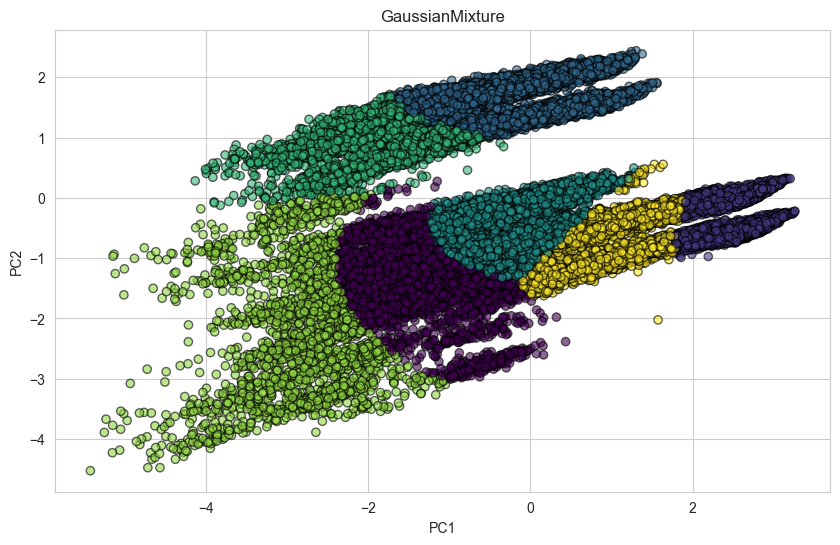

In [79]:
plt.figure(figsize=(10, 6))
plt.scatter(X_sample[:, 0], X_sample[:, 1], c=gm_labels, cmap='viridis', alpha=0.6, edgecolors='black', linewidths=1)
plt.title('GaussianMixture')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Выводы

KMeans

Силуэтный коэффициент равен 0.5261. Он положительный, находится почти посередине между 0 и 1. Значит, большинство точек данных назначены в подходящие кластеры, но кластеризация ещё не является оптимальной.

ARI равно 0.013077. Значение положительное, но близкое к 0. Это означает, что разбиение практически не похоже на истинное разбиение данных.

NMI равно 0.00218. Значение положительное, но близкое к 0. Это означает, что разбиение имеет слабое сходство с истинным разбиением данных.

DBSCAN

Силуэтный коэффициент равен 0.525426. Он положительный, находится почти посередине между 0 и 1. Значит, большинство точек данных назначены в подходящие кластеры, но кластеризация ещё не является оптимальной.

ARI равно 0.0029. Значение положительное, но близкое к 0. Это означает, что разбиение имеет слабое сходство с истинным разбиением данных.

NMI равно 3.687547773660231e-05. Значение положительное, но близкое к 0. Это означает, что разбиение практически не имеет сходства с истинным разбиением данных.

GMM

Силуэтный коэффициент равен 0.41044. Он положительный, находится почти посередине между 0 и 1. Значит, большинство точек данных назначены в подходящие кластеры, но кластеризация ещё не является оптимальной.

ARI равно 0.0216. Значение положительное, но близкое к 0. Это говорит о слабом качестве кластеризации.

NMI равно 0.0046. Значение положительное, но близкое к 0. Это означает, что разбиение практически не имеет сходства с истинным разбиением данных.

Вывод: все три метода показали низкое качество кластеризации на заданном наборе данных.